In [1]:
from fastai.text.all import *

In [2]:
path = Path('./data')
path

Path('data')

In [3]:
files = get_text_files(path, folders = ['train', 'test'])
files


(#148) [Path('data/train/bachcou.txt'),Path('data/train/25etude2.txt'),Path('data/train/sc_ps_03.txt'),Path('data/train/airnvari.txt'),Path('data/train/beethov.txt'),Path('data/train/be-pv07r.txt'),Path('data/train/allegro_.txt'),Path('data/train/pr_lud-1.txt'),Path('data/train/be-ps-05.txt'),Path('data/train/sy_sps94.txt')...]

In [4]:
txt = files[0].open().read(); txt[:100]

'wait25 wait5 p43 wait6 p31 p43 wait3 endp43 wait1 p47 wait3 endp47 wait1 p42 wait3 endp42 wait1 p43 '

In [5]:
txts = L(o.open().read() for o in files[:2000])

In [4]:
get_imdb = partial(get_text_files, folders=['train', 'test'])

In [5]:
dls_lm = DataBlock (
    blocks=TextBlock.from_folder(path, is_lm=True,tok=BaseTokenizer()), # other option is .from_df
    get_items=get_imdb,
    splitter=RandomSplitter(0.1)
).dataloaders(path, path=path, bs=128, seq_len=80)

In [12]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos p6 p18 p30 wait25 wait7 endp18 wait6 endp6 endp30 wait10 p17 p29 wait25 wait18 endp29 wait7 endp17 wait7 p10 p22 xxwrep 3 wait25 wait17 endp22 wait7 endp10 wait25 wait25 wait6 p25 p29 p34 p37 p46 wait1 p25 p41 wait2 endp29 endp34 endp37 wait3 endp25 endp41 wait2 endp46 wait8 p32 p41 p44 p49 wait3 p29 endp32 p37 endp41 wait2 endp37 endp44 wait2 endp49 wait3 endp29 wait6 p31 p36 endp36 p40 endp40 p43 endp43 p48 wait2 p28 endp31 endp48 wait2 endp28,p6 p18 p30 wait25 wait7 endp18 wait6 endp6 endp30 wait10 p17 p29 wait25 wait18 endp29 wait7 endp17 wait7 p10 p22 xxwrep 3 wait25 wait17 endp22 wait7 endp10 wait25 wait25 wait6 p25 p29 p34 p37 p46 wait1 p25 p41 wait2 endp29 endp34 endp37 wait3 endp25 endp41 wait2 endp46 wait8 p32 p41 p44 p49 wait3 p29 endp32 p37 endp41 wait2 endp37 endp44 wait2 endp49 wait3 endp29 wait6 p31 p36 endp36 p40 endp40 p43 endp43 p48 wait2 p28 endp31 endp48 wait2 endp28 wait12
1,wait3 p21 p33 wait3 endp21 endp33 wait1 p17 endp17 p29 endp29 wait2 p15 p27 wait3 p12 endp12 endp15 p24 endp24 endp27 wait3 p9 p21 wait3 endp9 endp21 wait1 p7 endp7 p19 endp19 wait2 p6 p18 wait5 endp6 endp18 wait1 p26 p33 p36 p38 p50 wait3 p26 p33 p36 wait3 p26 p33 p36 wait5 endp38 endp50 wait1 p26 p33 p36 p39 p51 wait5 endp33 endp36 wait1 p14 p26 wait5 endp14 endp39 endp51 wait1 p26 p33 p36 p38 p50 wait5 endp26 endp33,p21 p33 wait3 endp21 endp33 wait1 p17 endp17 p29 endp29 wait2 p15 p27 wait3 p12 endp12 endp15 p24 endp24 endp27 wait3 p9 p21 wait3 endp9 endp21 wait1 p7 endp7 p19 endp19 wait2 p6 p18 wait5 endp6 endp18 wait1 p26 p33 p36 p38 p50 wait3 p26 p33 p36 wait3 p26 p33 p36 wait5 endp38 endp50 wait1 p26 p33 p36 p39 p51 wait5 endp33 endp36 wait1 p14 p26 wait5 endp14 endp39 endp51 wait1 p26 p33 p36 p38 p50 wait5 endp26 endp33 endp36


In [7]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

In [15]:
learn.save('1epoch')

Path('data/models/1epoch.pth')

SuggestedLRs(lr_min=0.0005248074419796466, lr_steep=7.585775847473997e-07)

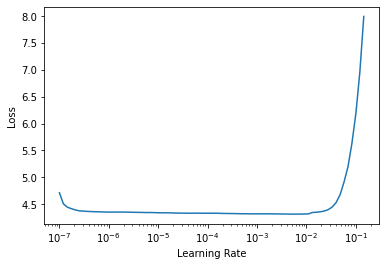

In [12]:
learn.lr_find()

In [14]:
learn.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.478635,3.497647,0.179205,33.037632,44:42


In [8]:
learn = learn.load('1epoch')

In [16]:
learn.unfreeze()
learn.fit_one_cycle(4, 2e-3)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.641453,1.869967,0.501366,6.488079,45:05
1,1.097370,1.628459,0.556926,5.096016,47:07
2,0.885959,1.680030,0.561083,5.365716,46:38
3,0.764732,1.719099,0.560181,5.579499,48:01


In [17]:
learn.save('1epoch')

Path('data/models/1epoch.pth')

In [19]:
# predict one note
review = "p35 p50 wait2 endp35 endp50 wait1 p38 p47 wait2 endp38 endp47 wait1 "
learn.predict(review)

'p35 p50 wait2 endp35 endp50 wait1 p38 p47 wait2 endp38 endp47 wait1 p40'

In [9]:
TEXT = "p16 wait3 p23 wait3 p28 wait2 endp16 wait1 p31 wait2 endp23 endp31 wait1 p35 wait2 endp28 endp35 wait1 p40 wait3 p35 wait3 p31 wait2 endp40 wait1 p16 wait2 endp35 wait1 p24 wait2 endp31 wait1 p28 wait2 endp16 wait1 p30 wait2 endp24 endp30 wait1 p33 wait2 endp28 endp33 wait1 p39 wait3 p33 wait3 p30 wait2 endp39 wait1 p16 wait2 endp33 wait1 p23 wait2 endp30 wait1 p28 wait2 endp16 wait1 p31 wait2 endp23 endp31 wait1 p35 wait2 endp28 endp35 wait1 p40 wait3 p35 wait3 p31 wait2 endp40 wait1 p16 wait2 endp35 wait1 p24 wait2 endp31 wait1 p28 wait2 endp16 wait1 p30 wait2 endp24 endp30 wait1 p33 wait2 endp28 endp33 wait1 p39 wait3 p33 wait3 p30 wait2 endp39 wait1 p16 wait2 endp33 wait1 p23 wait2 endp30 wait1 p28 wait2 endp16 wait1 p31 wait2"
N_WORDS = 3600
N_SENTENCES = 1
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [11]:
with open('/home/scott/code/musical-neural-net-master/result/sample.txt', mode='w') as f:
    f.write(preds[0])

In [2]:

import os
from pathlib import Path
import numpy as np
import pandas as pd
from math import floor
import music21
import random
import dill as pickle

In [3]:
def write_midi(s, filename, output_folder):
    fp = s.write('midi', fp=output_folder/filename)
    
def string_inds_to_stream(string, sample_freq, note_offset, chordwise):
    score_i = string.split(" ")
    if chordwise:
        return arrToStreamChordwise(score_i, sample_freq, note_offset)
    else:
        return arrToStreamNotewise(score_i, sample_freq, note_offset)

def arrToStreamChordwise(score, sample_freq, note_offset):

    speed=1./sample_freq
    piano_notes=[]
    violin_notes=[]
    time_offset=0
    for i in range(len(score)):
        if len(score[i])==0:
            continue

        for j in range(1,len(score[i])):
            if score[i][j]=="1":
                duration=2
                new_note=music21.note.Note(j+note_offset)    
                new_note.duration = music21.duration.Duration(duration*speed)
                new_note.offset=(i+time_offset)*speed
                if score[i][0]=='p':
                    piano_notes.append(new_note)
                elif score[i][0]=='v':
                    violin_notes.append(new_note)
    violin=music21.instrument.fromString("Violin")
    piano=music21.instrument.fromString("Piano")
    violin_notes.insert(0, violin)
    piano_notes.insert(0, piano)
    violin_stream=music21.stream.Stream(violin_notes)
    piano_stream=music21.stream.Stream(piano_notes)
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return main_stream
                    
def arrToStreamNotewise(score, sample_freq, note_offset):
    speed=1./sample_freq
    piano_notes=[]
    violin_notes=[]
    time_offset=0
    
    i=0
    while i<len(score):
        if score[i][:9]=="p_octave_":
            add_wait=""
            if score[i][-3:]=="eoc":
                add_wait="eoc"
                score[i]=score[i][:-3]
            this_note=score[i][9:]
            score[i]="p"+this_note
            score.insert(i+1, "p"+str(int(this_note)+12)+add_wait)
            i+=1
        i+=1
        
    for i in range(len(score)):
        if score[i] in ["", " ", "<eos>", "<unk>"]:
            continue
        elif score[i][:3]=="end":
            if score[i][-3:]=="eoc":
                time_offset+=1
            continue
        elif score[i][:4]=="wait":
            time_offset+=int(score[i][4:])
            continue
        else:
            # Look ahead to see if an end<noteid> was generated
            # soon after.  
            duration=1
            has_end=False
            note_string_len = len(score[i])
            for j in range(1,200):
                if i+j==len(score):
                    break
                if score[i+j][:4]=="wait":
                    duration+=int(score[i+j][4:])
                if score[i+j][:3+note_string_len]=="end"+score[i] or score[i+j][:note_string_len]==score[i]:
                    has_end=True
                    break
                if score[i+j][-3:]=="eoc":
                    duration+=1

            if not has_end:
                duration=12

            add_wait = 0
            if score[i][-3:]=="eoc":
                score[i]=score[i][:-3]
                add_wait = 1

            try: 
                new_note=music21.note.Note(int(score[i][1:])+note_offset)    
                new_note.duration = music21.duration.Duration(duration*speed)
                new_note.offset=time_offset*speed
                if score[i][0]=="v":
                    violin_notes.append(new_note)
                else:
                    piano_notes.append(new_note)                
            except:
                print("Unknown note: " + score[i])

            

            
            time_offset+=add_wait
                
    violin=music21.instrument.fromString("Violin")
    piano=music21.instrument.fromString("Piano")
    violin_notes.insert(0, violin)
    piano_notes.insert(0, piano)
    violin_stream=music21.stream.Stream(violin_notes)
    piano_stream=music21.stream.Stream(piano_notes)
    main_stream = music21.stream.Stream([violin_stream, piano_stream])
    return main_stream

def write_mid_mp3_wav(stream, fname, sample_freq, note_offset, out, chordwise):
    stream_out=string_inds_to_stream(stream, sample_freq, note_offset, chordwise)
    write_midi(stream_out, fname, out)
    base=out/fname[:-4]
    os.system(f'./data/mid2mp3.sh {base}.mid')
    os.system(f'mpg123 -w {base}.wav {base}.mp3')

In [22]:
preds[0]

'p23 wait4 p26 wait1 endp23 wait1 p30 wait1 endp26 wait1 endp30 wait3 endp30 wait1 p35 wait5 endp35 wait1 p38 wait5 endp38 wait1 p42 wait5 endp42 wait1 p45 wait5 endp45 wait1 p47 wait5 endp47 wait1 p47 wait5 endp47 wait1 p45 wait5 endp45 wait1 p42 wait5 endp42 wait1 p38 wait5 endp38 wait1 p30 wait5 endp30 wait1 p28 wait5 endp28 wait1 p21 wait5 endp21 wait1 p18 wait5 endp18 wait1 p14 wait5 endp14 wait1 p7 wait5 endp7 wait1 p9 wait6 p21 wait1 endp9 wait5 endp21 wait1 p26 wait4 p23 wait1 endp26 wait4 p17 endp23 wait5 endp17 wait1 p9 wait5 endp9 wait1 p9 wait5 endp9 wait1 p11 wait5 endp11 wait1 p9 wait5 endp9 wait1 p7 wait6 p6 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p4 wait6 p1 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait6 p2 wait5 endp0 wait1 p2 wait6 p2 wait5 endp2 wait1 p2 wait6 p2 wait5 endp2 wait1 p0 wait6 p6 wait5 endp3 wait1 p4 wait6 p9 wait5 endp4 wai

In [1]:
a = 'p33 p39 wait3 endp39 wait3 p37 wait5 endp37 wait1 p36 wait5 endp33 endp36 wait1 p37 p52 wait5 endp37 endp52 wait1 p32 p51 wait5 endp51 wait1 p49 wait5 endp49 wait1 p48 wait5 endp48 wait1 p40 p49 wait1 endp32 wait1 endp40 wait3 endp49 wait1 p30 p39 p47 wait5 endp39 endp47 wait1 p37 p45 wait5 endp37 endp45 wait1 p36 p44 wait5 p39 wait3 endp39 wait3 p37 wait5 endp37 wait1 p36 wait5 endp33 endp36 wait1 p37 p52 wait5 endp37 endp52 wait1 p32 p51 wait5 endp51 wait1 p49 wait5 endp49 wait1 p48 wait5 endp48 wait1 p40 p49 wait1 endp32 wait1 endp40 wait3 endp49 wait1 p30 p39 p47 wait5 endp39 endp47 wait1 p37 p45 wait5 endp37 endp45 wait1 p36 p44 wait5 endp36 endp44 wait1'

In [20]:
write_mid_mp3_wav(a, 'test.mid', 12, 33, Path('./data'), False)

KeyError: 40

In [11]:
data_folder = Path('./result/mid')
data_folder

Path('result/mid')

In [17]:
from IPython.display import Audio
audio_files = data_folder.ls()
audio_files

(#1) [Path('result/mid/Bach_2PartInv_No1_in_C_BWV772.mid')]

In [18]:
from IPython.display import Audio
audio_files = data_folder.ls()
example = audio_files[0]
Audio(str(example))